In [1]:
import torch

from utils import load_model
from models.get_model import get_model
from dataset import UltrasonicDataset
from torchvision.transforms import v2

import json
from matplotlib import pyplot as plt
import cv2
import numpy as np


In [2]:
run_name = "2023-11-18_16-23-20"

run_path = f"runs/{run_name}/"

In [3]:
train_summary = json.load(open(run_path + "train_summary.json"))

model_name = train_summary["config"]["MODEL"]
IMAGE_SIZE = train_summary["config"]["IMAGE_SIZE"]

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
model = get_model(model_name, IMAGE_SIZE)
model = model.to(DEVICE)

model = load_model(model, run_path + "best_model.pth")

[54 69  0 21 87 66 77 15]


/tmp/ipykernel_692308/2657257565.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(mask).unsqueeze(0).unsqueeze(0).float()


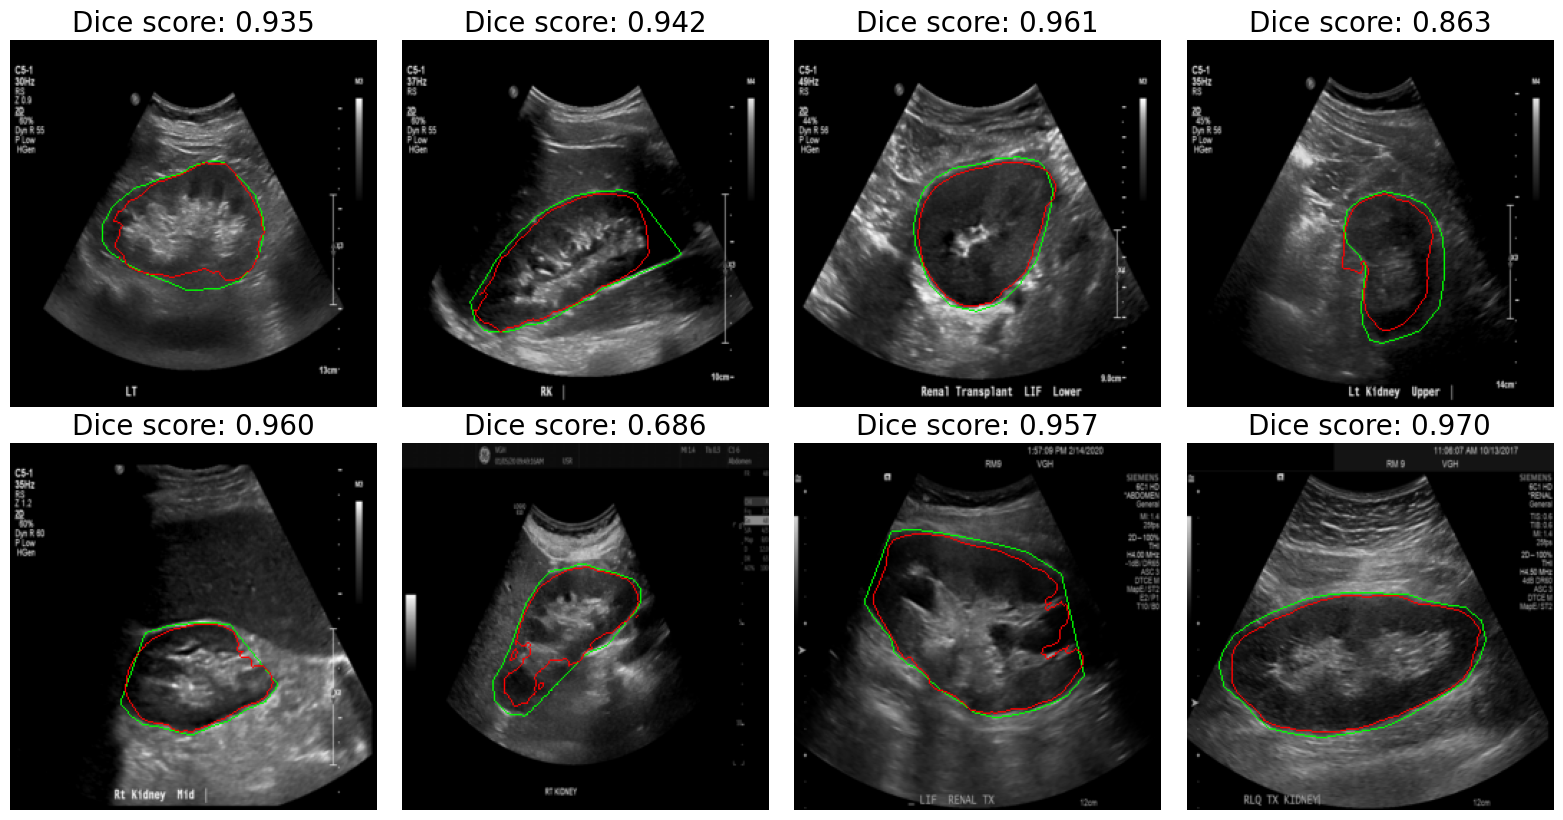

In [10]:
transforms_test = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32),
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
])

dataset_test = UltrasonicDataset("datasets/OpenKidney/test", transforms_test)

indices = np.random.randint(len(dataset_test), size=8)
np.random.shuffle(indices)
# indices = [ 90, 63, 0, 53, 49, 99, 92, 89]

print(indices)

fig = plt.figure(figsize=(20, 10))

for i in range(8):

    index = indices[i]

    img, mask = dataset_test[index]


    with torch.no_grad():
        model.eval()
        img_tensor = img.unsqueeze(0).to(DEVICE)
        pred = model(img_tensor)
        if model._get_name() == "LRASPP":
            pred = pred["out"]

        if model._get_name() == "MobileViTV2ForSemanticSegmentation" or\
            model._get_name() == "SegformerForSemanticSegmentation":
            pred = pred[0]
            pred = torch.nn.functional.interpolate(pred, size=(256, 256), mode='bilinear', align_corners=False)
        # pred = torch.sigmoid(pred)
        pred = pred


    pred_mask = pred.squeeze(0).argmax(0).cpu().numpy()
    # pred_mask = pred_mask > 0.5

    target = torch.tensor(mask).unsqueeze(0).unsqueeze(0).float()
    pred = pred.cpu()

    from monai.metrics import DiceMetric
    from monai.transforms import Compose, AsDiscrete
    from monai.data import decollate_batch


    post_label = Compose([AsDiscrete(to_onehot=2)])
    post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
    dice_acc = DiceMetric(include_background=False, get_not_nans=True)


    val_labels_list = decollate_batch(target)
    val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]

    val_outputs_list = decollate_batch(pred)
    val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]

    dice_acc(y_pred=val_output_convert, y=val_labels_convert)

    dice = dice_acc.aggregate()[0].cpu().numpy()[0]

    # print(f"Dice score: {dice}")

    # get boundary of masks with openCV

    # create an empty image for contours
    img_contours = img.numpy().squeeze(0).copy() * 255
    img_contours = cv2.cvtColor(img_contours.astype(np.uint8), cv2.COLOR_GRAY2RGB)

    # find contours of GT maks
    contours, hierarchy = cv2.findContours((mask[0].numpy() * 255).astype(np.uint8),  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 1)


    # find contours of predicted maks
    contours, hierarchy = cv2.findContours((pred_mask * 255).astype(np.uint8),  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(img_contours, contours, -1, (255, 0, 0), 1)

    # show the image with the drawn contours
    plt.subplot(2, 4, i + 1)
    plt.imshow(img_contours, cmap="gray")
    plt.axis("off")
    plt.title(f"Dice score: {dice:.3f}", fontsize=20)


fig.subplots_adjust(wspace=0.05, hspace=0.1)


(-0.5, 255.5, 255.5, -0.5)

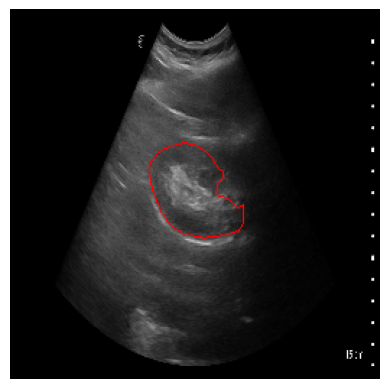

In [37]:
real_img = cv2.imread("images/test.jpeg", cv2.IMREAD_GRAYSCALE)
real_img = cv2.resize(real_img, (IMAGE_SIZE, IMAGE_SIZE))
real_img = real_img.astype(np.float32) / 255.0
real_img = np.expand_dims(real_img, axis=2)

# convere to tensor
real_img = transforms_test(real_img).unsqueeze(0).to(DEVICE)

with torch.no_grad():
    model.eval()
    pred = model(real_img)
    if model._get_name() == "LRASPP":
        pred = pred["out"]

    if model._get_name() == "MobileViTV2ForSemanticSegmentation" or\
        model._get_name() == "SegformerForSemanticSegmentation":
        pred = pred[0]
        pred = torch.nn.functional.interpolate(pred, size=(256, 256), mode='bilinear', align_corners=False)
    # pred = torch.sigmoid(pred)

# pred_mask = torch.sigmoid(pred.squeeze(0)).cpu().numpy()
pred_mask = torch.softmax(pred.squeeze(0), dim=0).cpu().numpy()
pred_mask = pred_mask[1, :, :]
pred_mask = pred_mask > 0.5

# get boundary of masks with openCV

# create an empty image for contours
img_contours = real_img.cpu().numpy().squeeze(0).squeeze(0).copy() * 255

img_contours = cv2.cvtColor(img_contours.astype(np.uint8), cv2.COLOR_GRAY2RGB)

# find contours of GT maks
contours, hierarchy = cv2.findContours((pred_mask * 255).astype(np.uint8),  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(img_contours, contours, -1, (255, 0, 0), 1)

# show the image with the drawn contours
plt.imshow(img_contours, cmap="gray")
plt.axis("off")



In [31]:
real_video_path = "datasets/test_kidney_video.mp4"

cap = cv2.VideoCapture(real_video_path)

# Check if camera opened successfully
if (cap.isOpened()== False):
    print("Error opening video stream or file")

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Read until video is completed

while(cap.isOpened()):

    # Capture frame-by-frame
    ret, real_img = cap.read()
    if not ret:
        break

    real_img = cv2.cvtColor(real_img, cv2.COLOR_BGR2GRAY)
    real_img = cv2.resize(real_img, (IMAGE_SIZE, IMAGE_SIZE))
    real_img = real_img.astype(np.float32) / 255.0
    real_img = np.expand_dims(real_img, axis=2)

    # convere to tensor
    real_img = transforms_test(real_img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        model.eval()
        pred = model(real_img)
        if model._get_name() == "LRASPP":
            pred = pred["out"]

        if model._get_name() == "MobileViTV2ForSemanticSegmentation" or\
            model._get_name() == "SegformerForSemanticSegmentation":
            pred = pred[0]
            pred = torch.nn.functional.interpolate(pred, size=(256, 256), mode='bilinear', align_corners=False)
        # pred = torch.sigmoid(pred)

    # pred_mask = torch.sigmoid(pred.squeeze(0)).cpu().numpy()
    pred_mask = torch.softmax(pred.squeeze(0), dim=0).cpu().numpy()
    pred_mask = pred_mask[1, :, :]
    pred_mask = pred_mask > 0.9
    # pred_mask = pred.squeeze(0).argmax(0).cpu().numpy()
   

    # get boundary of masks with openCV

    # create an empty image for contours
    img_contours = real_img.cpu().numpy().squeeze(0).squeeze(0).copy() * 255

    img_contours = cv2.cvtColor(img_contours.astype(np.uint8), cv2.COLOR_GRAY2RGB)

    # find contours of GT maks
    contours, hierarchy = cv2.findContours((pred_mask * 255).astype(np.uint8),  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(img_contours, contours, -1, (255, 0, 0), 1)


    # resize frame
    # frame = cv2.resize(frame, (width//3, height//3))
    # Display the resulting frame
    cv2.imshow('Frame',img_contours)

    # Press Q on keyboard to  exit
    if cv2.waitKey(5) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()